# McStas data to MJOLNIR data format, conversion script for BIFROST

by: Kristine M. L. Krighaar

created: 18/01/2024

In [1]:
from KGS import * # Utilizing my own package for data analysis. Remember to also send enviroment when sharing. 
import scipp as sc
import scippneutron as scn
from scippneutron.conversion import graph
import os
from IPython.display import Image
import h5py
import sys
from TubeMeasurment_mccode import tube_measurement


## Data reduction process

Full overview of how converison is done: 

## Exporting dataformat for as .txt MJOLNIR

In [2]:
#tube_measurement.load_scan('incoherent_1_tube','incoherent_1_tube_data',set_Elim=(-1,7))

# DATA TREATMENT FOR INCOHERENT

In [3]:
settings = np.loadtxt('incoherent_1_tube_data').T

## plotting Intensities to see distribution! 

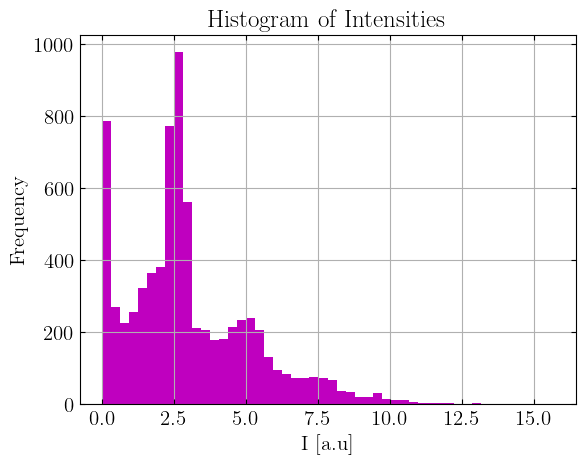

In [4]:
data_flat = settings[0]

# Create a histogram
plt.hist(data_flat[(data_flat>0.0001)], bins=50, color='m')  # Adjust the number of bins as needed
plt.xlabel('I [a.u]')
plt.ylabel('Frequency')
plt.title('Histogram of Intensities')
plt.grid(True)
plt.show()

In [5]:

"""
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot data: I, I_err, DeltaE, qx, qy
ax.scatter(settings[3], settings[4], settings[2], c=settings[0])

ax.set_xlabel('qx')
ax.set_ylabel('qy')
ax.set_zlabel('DeltaE')
ax.set_title('tube measuring surface')
plt.show()
"""

"\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\n\n# Plot data: I, I_err, DeltaE, qx, qy\nax.scatter(settings[3], settings[4], settings[2], c=settings[0])\n\nax.set_xlabel('qx')\nax.set_ylabel('qy')\nax.set_zlabel('DeltaE')\nax.set_title('tube measuring surface')\nplt.show()\n"

# Scipp binning of one instrument setting

In [6]:


qx = sc.array(dims=["row"], values=settings[3], unit="Å^(-1)")
qy = sc.array(dims=["row"], values=settings[4], unit="Å^(-1)")
deltaE = sc.array(dims=["row"], values=settings[2], unit="meV")
Q = sc.array(dims=["row"], values=np.sqrt(settings[3]**2+settings[4]**2), unit="Å^(-1)")

recording = sc.DataArray(
    data=sc.array(dims=["row"], values=settings[0], unit="arb. units", variances=settings[1]),  #, variances=settings[1]
    coords={"qx": qx, "qy": qy, "deltaE":deltaE, "Q":Q}
)

sliced = recording.bin(qx=400, qy=400, deltaE=300)
slicedQ = recording.bin(deltaE=170, Q=120)

sc.show(sliced)
sliced = sliced.bins.mean()
sliced

slicedQ = slicedQ.bins.mean()
slicedQ

<scipp.DataArray>
Dimensions: Sizes[deltaE:170, Q:120, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.712206, 0.734719, ..., 3.39126, 3.41378]
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-0.999998, -0.95294, ..., 6.9528, 6.99985]
Data:
                            float64      [arb. unit]  (deltaE, Q)  [0, 0, ..., 0, 0]  [0, 0, ..., 0, 0]

In [7]:
E_min = 4.5 * sc.Unit('meV')
E_max = 5.5 * sc.Unit('meV')

Q_min = 1.5 * sc.Unit('Å^(-1)')
Q_max = 3 * sc.Unit('Å^(-1)')



p3 = slicedQ['Q',Q_min:Q_max]['deltaE', E_min:E_max]
p4 = sc.mean(p3, dim='Q')

# Gauss fit for line
deltaE = p4.coords['deltaE'].values
deltaE  = (deltaE[:-1] + deltaE[1:]) / 2.0
I = np.nan_to_num(p4.values, nan=0)

def in_line(x, A, mu, sigma, b):
    return gauss(x, A, mu, sigma)#+b


guess = {'A':3, 'mu':5.0, 'sigma':5.6949e-2,'b':0.0}
lim = {'A':(2.7, 3.1),'b': (0.0001, 0.1)}
in_fit = fit(deltaE, p4.values, p4.variances, in_line, guess, limits=lim)

mu = np.average(deltaE, weights=I)
FWHM = np.sqrt(np.average((deltaE-mu)**2, weights=I))*2.3548
print(mu)
print(FWHM)
print(in_fit.values[2]*2.35)

in_fit.hesse()



5.005820640667677
0.15537958846113656
0.13365562250780438


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.806e+06                  │              Nfcn = 171              │
│ EDM = 1.26e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │   Hesse FAILED   │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A     │    3.1    │    0.0    │            │            │   2.7   │   3.1   │       │
│ 1 │ mu    │  5.0111   │  0.0000   │            │            │         │         │       │
│ 2 │ sigma │ 5.6875e-2 │ 0.0000e-2 │            │            │         │         │       │
│ 3 │ b     │ 1.001e-4  │ 0.000e-4  │            │            │ 0.0001  │   0.1   │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

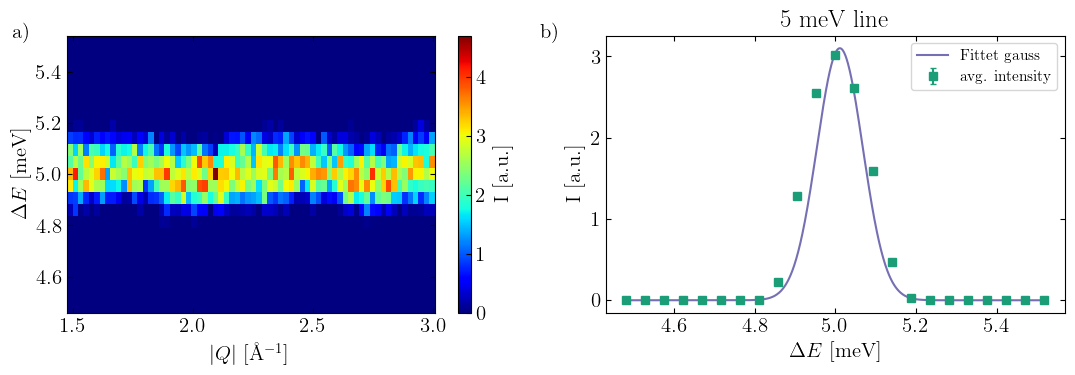

In [8]:

fig, ax = plt.subplots(1, 2, figsize=(11, 4))

plot = ax[0].pcolormesh(p3.coords['Q'].values, p3.coords['deltaE'].values, p3.values, cmap='jet')
cbar = plt.colorbar(plot, label='I [a.u.]')
ax[0].set_ylabel(r'$\Delta E$ [meV]')
ax[0].set_xlabel(r'$|Q|$ [Å$^{-1}$]')


ax[1].errorbar(deltaE, p4.values, yerr=p4.variances, fmt='s', label='avg. intensity')
x_range = np.linspace(min(deltaE), max(deltaE), 1000)
ax[1].plot(x_range, in_line(x_range, *in_fit.values),label='Fittet gauss')
ax[1].set_title('5 meV line')
ax[1].set_xlabel(r'$\Delta E$ [meV]')
ax[1].set_ylabel(r'I [a.u.]')
ax[1].legend(fontsize=11)

# Add labels to subplots
ax[0].text(-0.1, 1.05, 'a)', transform=ax[0].transAxes, va='top', ha='right', fontsize=15)
ax[1].text(-0.1, 1.05, 'b)', transform=ax[1].transAxes, va='top', ha='right', fontsize=15)

# Adjust layout
plt.tight_layout()
plt.savefig('5mev_line_1tube.pdf', format='pdf', bbox_inches='tight')


/Users/kristinekrighaar/opt/anaconda3/lib/python3.9/site-packages/scipp/core/deprecation.py:7: VisibleDeprecationWarning: sc.DataArray.attrs has been deprecated and will be removed in Scipp v24.12.0. The deprecation includes sc.DataArray.meta and sc.DataArray.drop_attrs. For unaligned coords, use sc.DataArray.coords and unset the alignment flag. For other attributes, use a higher-level data structure.
  warnings.warn(


Text(0.5, 15.134070194128777, '$|Q|$ [Å$^{-1}$]')

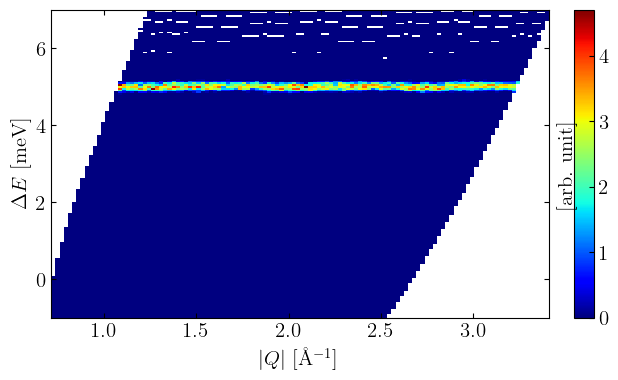

In [9]:

E_min = -2 * sc.Unit('meV')
E_max = 10 * sc.Unit('meV')

Q_min = 0 * sc.Unit('Å^(-1)')
Q_max = 3.5 * sc.Unit('Å^(-1)')

fig, ax = plt.subplots(1, 1, figsize=(7, 4))

p5 = slicedQ['Q',Q_min:Q_max]['deltaE', E_min:E_max].plot(ax=ax, cmap='jet')

ax.set_ylabel(r'$\Delta E$ [meV]')
ax.set_xlabel(r'$|Q|$ [Å$^{-1}$]')

In [10]:
qx_min = 0 * sc.Unit('Å^(-1)')
qx_max = 2 * sc.Unit('Å^(-1)')

qy_min = -3.0 * sc.Unit('Å^(-1)')
qy_max = 3.0 * sc.Unit('Å^(-1)')


#p1 = sliced['deltaE', E_layer]['qy', qy_min:qy_max].transpose().plot(ax=ax[0], cmap='jet')
#ax[0].set_xlim(0,2)
#ax[0].set_ylim(-0,-2)
#p2 = sliced['deltaE', E_min:E_max]['qy', qy_layer].transpose().plot(ax=ax[1], cmap='jet')
#p3 = slicedQ['deltaE', E_min:E_max]['Q',Q_min:Q_max]

# DATATREATMENT FOR POWDER - (long name)

In [11]:
settings_1 = np.loadtxt('powder_NAC_data1').T

powder = settings_1 #np.hstack((settings_1,settings_2))

print(len(settings_1[0]))


3241080


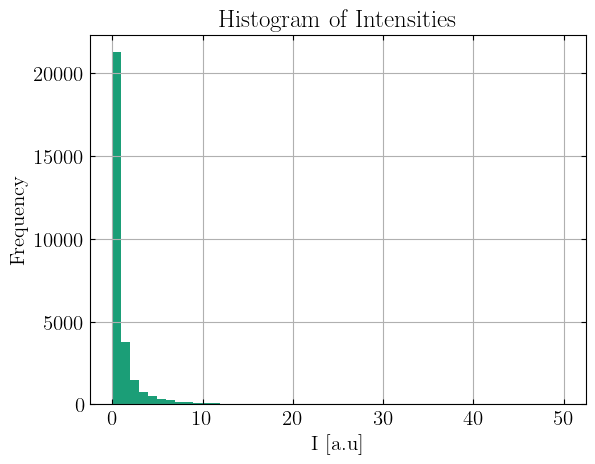

In [12]:
data_flat = powder[0]

# Create a histogram
plt.hist(data_flat[(data_flat>0.0001)], bins=50)  # Adjust the number of bins as needed
plt.xlabel('I [a.u]')
plt.ylabel('Frequency')
plt.title('Histogram of Intensities')
plt.grid(True)
plt.show()

In [13]:
qx = sc.array(dims=["row"], values=powder[3], unit="Å^(-1)")
qy = sc.array(dims=["row"], values=powder[4], unit="Å^(-1)")
deltaE = sc.array(dims=["row"], values=powder[2], unit="meV")
Q = sc.array(dims=["row"], values=np.sqrt(powder[3]**2+powder[4]**2), unit="Å^(-1)")

recording = sc.DataArray(
    data=sc.array(dims=["row"], values=powder[0], unit="Å^(-1)", variances=powder[1]), 
    coords={"qx": qx, "qy": qy, "deltaE":deltaE, "Q":Q}
)

sliced = recording.bin(qx=400, qy=400, deltaE=300)
slicedQ = recording.bin(deltaE=300, Q=400)

sc.show(sliced)
sliced = sliced.bins.mean()
sliced

slicedQ = slicedQ.bins.mean()
slicedQ

<scipp.DataArray>
Dimensions: Sizes[deltaE:300, Q:400, ]
Coordinates:
* Q                         float64           [1/Å]  (Q [bin-edge])  [0.712206, 0.72014, ..., 3.87774, 3.88567]
* deltaE                    float64            [meV]  (deltaE [bin-edge])  [-0.999998, -0.973332, ..., 6.97319, 6.99985]
Data:
                            float64           [1/Å]  (deltaE, Q)  [0, 0, ..., nan, nan]  [0, 0, ..., nan, nan]

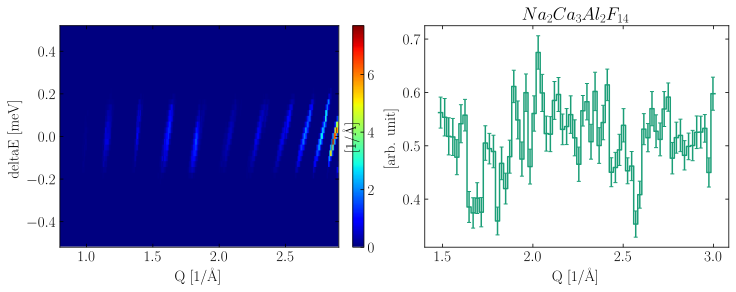

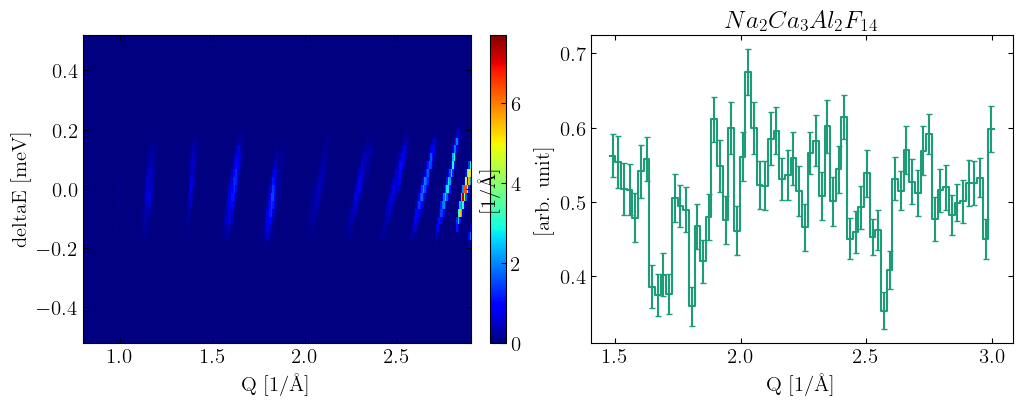

In [14]:
E_min = -0.5 * sc.Unit('meV')
E_max = 0.5 * sc.Unit('meV')

Q_min = 0.8 * sc.Unit('Å^(-1)')
Q_max = 2.9 * sc.Unit('Å^(-1)')

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
p6 = slicedQ['Q',Q_min:Q_max]['deltaE', E_min:E_max]
p6.plot(ax=ax[0], cmap='jet')
p7 = sc.mean(p3, dim='deltaE')
p7.plot(title='$Na_2Ca_3Al_2F_{14}$',  ax=ax[1])

Text(0, 0.5, 'I [a.u.]')

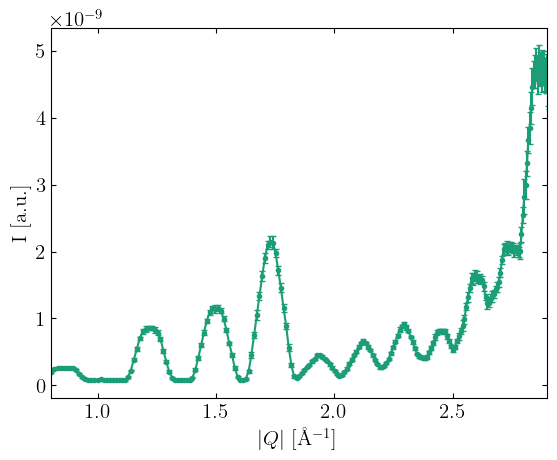

In [15]:
pow_ref = np.loadtxt('monitor_nd_NAC_reference.th_y').reshape(3,-1,270)

twotheta = np.linspace(30,165,270)
lam = 1/(0.11056*np.sqrt(5))
k = (2*np.pi)/lam
Q = 2*k*np.sin(np.radians(twotheta/2))

# Calculate weighted mean along a certain axis
weighted_mean_values = np.average(pow_ref[0], axis=0, weights=pow_ref[1])

# Calculate weighted standard deviation along a certain axis
weighted_std_values = np.sqrt(np.average((pow_ref[0] - weighted_mean_values)**2, axis=0, weights=pow_ref[1]))

plt.errorbar(Q, weighted_mean_values, weighted_std_values, fmt='.-')
plt.xlabel(r'$|Q|$ [Å$^{-1}$]')
plt.xlim(min(Q), 2.9)
plt.ylabel(r'I [a.u.]')
